In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import scipy
import brmbs.data.DataLoader as dl

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Read and Clean Data

## 1.1.  Import and plot bechmark rates

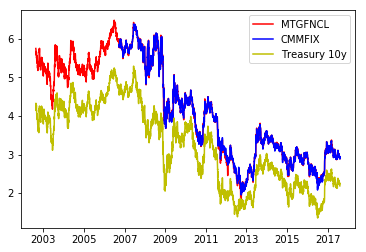

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
plt.plot(rate_Base_raw['Date'].values,rate_Base_raw['MTGFNCL'].values,c='r',label='MTGFNCL')
plt.plot(rate_Base_raw['Date'].values,rate_Base_raw['CMMFIX'].values,c='b',label='CMMFIX')
plt.plot(rate_Base_raw['Date'].values,rate_Base_raw['TR'].values,c='y',label='Treasury 10y')
plt.legend()
plt.show()

## 1.2. Utility function

In [3]:
def dtToIndex(date):
    return date.strftime("%Y-%m-%d")

## 1.3. Find top three issued coupon in each period

In [4]:
Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))
    
most_issued_list = pd.DataFrame({'Mostly Issued' : Most_issue, 'Secondly Issued' : Second_Most_issued, \
                                 'Thirdly Issued' : Third_Most_issued}, index = FN_issue.index)

In [5]:
date_index = np.unique(df.index)
date_index = date_index[date_index >= np.datetime64(dt.datetime.strptime(FN_issue.index[0], '%d-%b-%y'))]
issue_dist = pd.DataFrame(np.zeros((len(date_index), FN_issue.shape[1])), index = date_index, columns = all_coupons)

for d in most_issued_list.index:
    m_end = dt.datetime.strptime(d, '%d-%b-%y')
    m_begin = m_end - dt.timedelta(days = m_end.day - 1)
    dat = most_issued_list.ix[d]
    issue_dist[dat['Mostly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 1
    issue_dist[dat['Secondly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 2
    issue_dist[dat['Thirdly Issued']][dtToIndex(m_begin):dtToIndex(m_end)] = 3

In [6]:
class RegressionPeriod:
    def __init__(self, startDate, endDate, coupon, order, criteria=0.9):
        self.criteria = criteria
        self.startDate = startDate
        self.endDate = endDate
        self.coupon = coupon
        self.order = order

collapse_with_order = {}
collapse_without_order = {}
for c in issue_dist.columns:
    c_series = issue_dist[c]
    
    list_with_order = []
    list_without_order = []
    
    prev_order = -1
    prev_has_data = False
    prev_date = None
    for cur_date, cur_order in c_series.iteritems():
        if (not prev_has_data) and cur_order > 0:
            # get with_order Period
            cur_with_period = RegressionPeriod(cur_date, None, c, cur_order)
            
            # get without_order Period
            cur_without_period = RegressionPeriod(cur_date, None, c, None)
            
            prev_has_data = True
        elif prev_has_data and cur_order != prev_order:
            # get with_order Period
            cur_with_period.endDate = prev_date
            list_with_order.append(cur_with_period)
            cur_with_period = RegressionPeriod(cur_date, None, c, cur_order)
            
            # get without_order Period
            if cur_order == 0:
                cur_without_period.endDate = prev_date
                list_without_order.append(cur_without_period)
                
                prev_has_data = False
            
        prev_date = cur_date
        prev_order = cur_order
    
    if prev_has_data:
        # close last get with_order Period
        cur_with_period.endDate = prev_date
        list_with_order.append(cur_with_period)
        
        # close last get without_order Period
        cur_without_period.endDate = prev_date
        list_without_order.append(cur_without_period)
    
        prev_has_data = False
        
    collapse_without_order[c] = list_without_order
    collapse_with_order[c] = list_with_order

As shown in below table, for '2002-07-31', TBA6.5 is the most issued TBA, 6 is the second and 7 is the third. The inssuance rank will help us filter out unreliable prices for each period.

In [7]:
issue_dist.head()

,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0
2002-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0
2002-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0
2002-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0


# 2. Linear Rolling Regression

Only top 3 issued TBA will be used in the regression

In [16]:
precision = 4

def regression_roll_wind(wind, X, Y, add_constant = True):
    '''X and Y are series with index. wind is an integer'''
    
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    
    pure_X = X.values
    pure_Y = Y.values
    index = X.index[wind:]
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        
        if add_constant:
            mod = sm.OLS(reg_Y, sm.add_constant(reg_X))
            res = mod.fit()
        
            a, b = res.params
            beta.append(b)
        else:
            mod = sm.OLS(reg_Y, reg_X)
            res = mod.fit()
        
            b = res.params
            beta.append(b)
        
    return pd.DataFrame({'Duration': beta}, index = index)

In [42]:
default_window = 60

duration_without_order = {}
duration_without_order_wo_const = {}
for c, period_list in collapse_without_order.items():
    dat = params[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    cur_list_wo_const = []
    for p in period_list:
        # for rolling window, we use default_window (if rolling period > default_window), or rolling period / 2 + 1 (if < default_window)
        
        rolling_period = len(dat[p.startDate:p.endDate]['Rate Change'])
        
        if rolling_period == 0:
            continue
        
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['Rate Change'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
        
        betas_wo_const = regression_roll_wind(window, dat[reg_start_date:p.endDate]['Rate Change'], dat[reg_start_date:p.endDate]['Return'], \
                                              add_constant = False)
        betas_w_const = regression_roll_wind(window, dat[reg_start_date:p.endDate]['Rate Change'], dat[reg_start_date:p.endDate]['Return'])
        
        cur_list.append(betas_w_const)
        cur_list_wo_const.append(betas_wo_const)
        
    duration_without_order[c] = cur_list
    duration_without_order_wo_const[c] = cur_list_wo_const

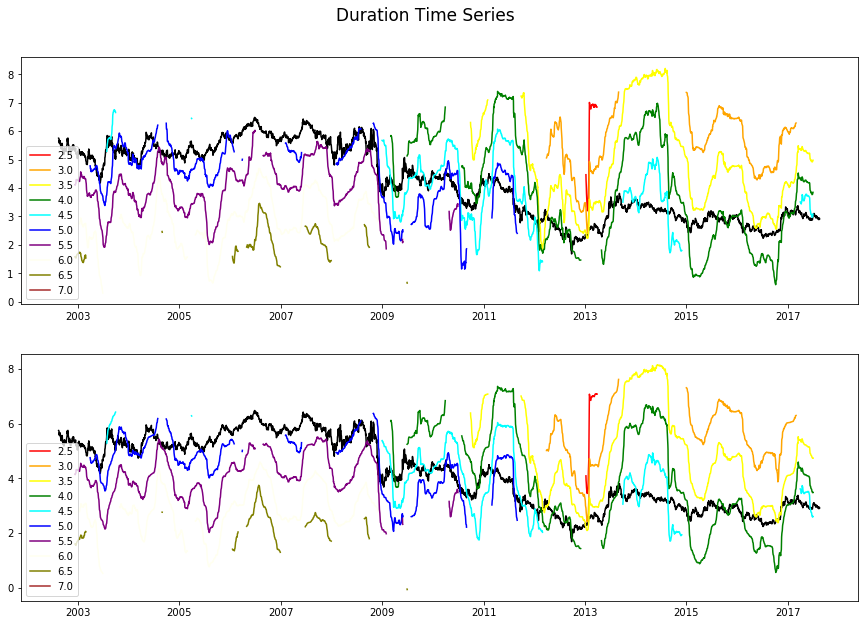

In [43]:
def getUniqLabel(handles, labels):
    uniq_label= {}
    for idx, lab in enumerate(labels):
        if lab not in uniq_label.keys():
            uniq_label[lab] = handles[idx]
    return uniq_label

color_code = {
    2.5: 'red',
    3.0: 'orange',
    3.5: 'yellow',
    4.0: 'green',
    4.5: 'cyan',
    5.0: 'blue',
    5.5: 'purple',
    6.0: 'ivory',
    6.5: 'olive',
    7.0: 'brown',
    7.5: 'khaki',
    8.0: 'mediumslateblue',
    
}

plt.figure(figsize = (15,10))
plt.suptitle('Duration Time Series', y=0.95, fontsize=17)
data=[duration_without_order.items(),duration_without_order_wo_const.items()]
for i, thisData in enumerate(data):
    ax=plt.subplot(2,1,i+1)
    plt.plot(rate_Base.index, rate_Base['MTGFNCL'].values, color = 'black')
    for c, duration_list in thisData:
        for d in duration_list:
            plt.plot(d.index, d.Duration, c = color_code[c], label=c)
    handles, labels = ax.get_legend_handles_labels()
    uniq_label=getUniqLabel(handles, labels)
    plt.legend(uniq_label.values(),uniq_label.keys()) 

# 3. Polynomial Rolling Regression

In [33]:
def duration_from_poly_fit(X, Y, deg):
    reg_size = len(X)
    coef = np.polyfit(X, Y, deg)
    rate = X[reg_size - 1]
    return - np.sum(coef[:-1] * rate**np.arange(deg - 1, -1, -1) * np.arange(deg, 0, -1)) 

def regression_poly_wind(wind, X, Y, deg):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    
    pure_X = X.values
    pure_Y = Y.values
    index = X.index[wind:]
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        beta.append(duration_from_poly_fit(reg_X, reg_Y, deg))
        
    return pd.DataFrame({'Duration': beta}, index = index)

In [34]:
default_window = 60
degree = 1

poly_duration_without_order = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    for p in period_list:
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['price'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
            
        betas = regression_poly_wind(window, dat[reg_start_date:p.endDate]['MTGFNCL'], dat[reg_start_date:p.endDate]['price'], degree)
        
        cur_list.append(betas)
        
    poly_duration_without_order[c] = cur_list

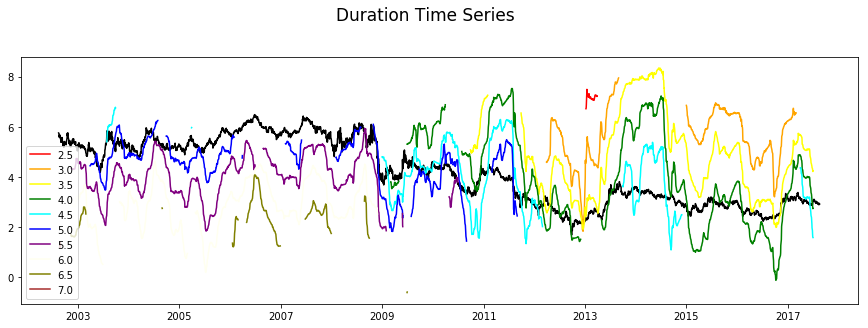

In [40]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Duration Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
ax.plot(rate_Base.index, rate_Base['MTGFNCL'].values, color = 'black')
for c, duration_list in poly_duration_without_order.items():
    for d in duration_list:
        ax.plot(d.index, d.Duration, c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 

# 4. Supplementary: Polynomial Fit for Whole Period

In [38]:
def poly_fit(X, Y, deg):
    return np.polyfit(X, Y, deg)

period_list = collapse_without_order[4.5]
concat_data = TBAs[4.5][:]
Y = concat_data.price.values
X = concat_data.MTGFNCL.values/100
degree = 3
coef_vars = poly_fit(X, Y, degree)
print('Coef: ',coef_vars)

Y_est = ((X.reshape(-1,1) * np.ones((1, degree + 1)))**np.arange(degree, -1, -1)).dot(coef_vars.reshape(-1,1)).squeeze()

Coef:  [  3.31921082e+05  -4.63285200e+04   1.57611914e+03   9.27522223e+01]


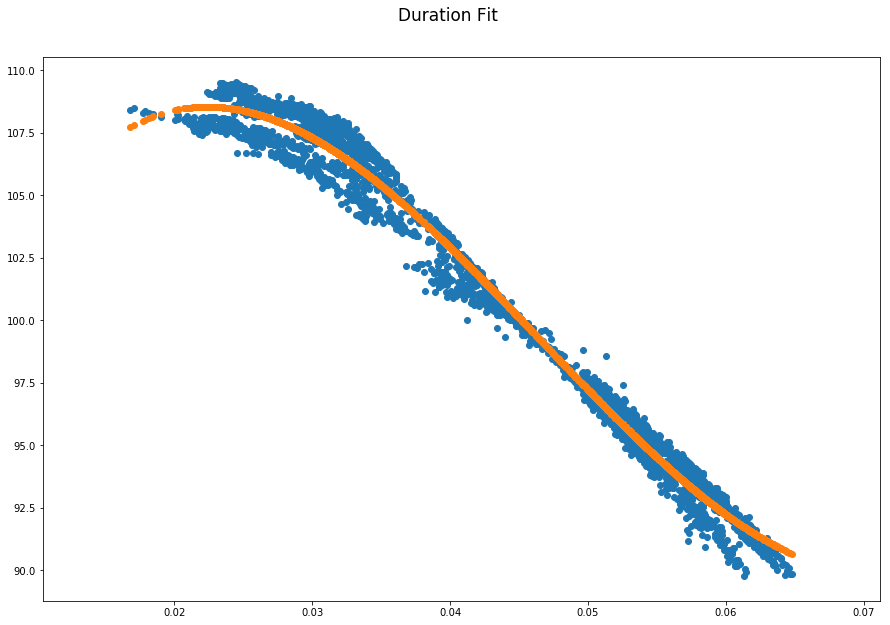

In [41]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Duration Fit', y=0.95, fontsize=17)
ax = fig.add_subplot(111)

ax.scatter(X, Y)
ax.scatter(X, Y_est)